# Alien Communication Classification
In this notebook, we are classifying alien species based on their communication, number of fingers, and the presence of a tail.

The goal is to accurately predict the species of aliens in the provided test data using machine learning models.

In [84]:
import re
import graphviz
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from nltk.metrics import edit_distance
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Embedding, LSTM, MultiHeadAttention, Concatenate
from keras.models import Model
import seaborn as sns

# Importing the Required Libraries
First, we import the necessary libraries for data manipulation, visualization, and model building.

In [64]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

Let's load the dataset, which contains alien messages and their corresponding attributes, including the number of fingers and tail presence.

In [65]:
data = pd.read_csv('/kaggle/input/aries-iitd-alien/data.csv')

In [66]:
df = data

Here's a preview of the dataset, showing the first few rows to understand its structure.

In [83]:
df.head()

,message,fingers,tail,species,species_en,tail_en,message_en,words
0,pluvia arbor aquos,4,no,Aquari,0,0,pluvia arbor aquos,"[pluvia, arbor, aquos]"
1,cosmix xeno nebuz odbitaz,5,yes,Zorblax,9,1,cosmix xeno nebuz odbitaz,"[cosmix, xeno, nebuz, odbitaz]"
2,solarix glixx novum galaxum quasar,5,yes,Zorblax,9,1,solarix glixx novum galaxum quasar,"[solarix, glixx, novum, galaxum, quasar]"
3,arbor insectus pesros ekos dootix nimbus,2,yes,Florian,4,1,arbor insectus pesros ekos dootix nimbus,"[arbor, insectus, pesros, ekos, dootix, nimbus]"
4,mermax drakos lorix epikoz deftax,4,no,Faerix,3,0,mermax drakos lorix epikoz deftax,"[mermax, drakos, lorix, epikoz, deftax]"


# EDA Over Training Data

1.) Finding Count of Each Species

In [67]:
df['species'].value_counts()

species
Quixnar     60
Cybex       55
Emotivor    54
Florian     52
Zorblax     51
Mythron     50
Aquari      48
Sentire     44
Faerix      43
Nexoon      43
Name: count, dtype: int64

2.) Finding the max and min value of fingers for each specie & count of tails

In [68]:
range_df = df.groupby('species')['fingers'].agg(['min', 'max'])
count_df = df.groupby('species')['tail'].value_counts().unstack(fill_value=0)
result_df = pd.concat([range_df, count_df], axis=1)
result_df['tail'] = result_df.apply(lambda row: 'no' if row['no'] > row['yes'] else 'yes', axis=1)
result_df

,min,max,no,yes,tail
species,,,,,
Aquari,2,6,44,4,no
Cybex,0,4,48,7,no
Emotivor,0,3,36,18,no
Faerix,2,5,34,9,no
Florian,0,5,9,43,yes
Mythron,3,8,9,41,yes
Nexoon,1,7,7,36,yes
Quixnar,2,6,46,14,no
Sentire,2,6,8,36,yes


3.) Finding the Number of Total words & Unique Words in Training Data

In [69]:
training_words = []
for msg in df['message']:
    for word in msg.split():
        training_words.append(word)

print("Total Words:",len(training_words))

Total Words: 2719


Upon Exploratory Data Analysis of the data, we found out that there are a total of 636 words being used, out of which only 121 words used were repeated.

The words which were being used only once or twice were actually derived from other words, and there was only a small change in spelling.

For eg. Pluvia, Plybia, Phuvia these types of words are similiar with just 1-2 changes in the spelling.

We found out all such words, made a dictionary of similar words by calculating Levenshtein Distance between them. (Our threshold was 2)

Then we replaced all the words, such that in the new column ['message_en'], only 122 unique words were now there in the vocabulary.

In [70]:
vectorizer = CountVectorizer()

vectorizer.fit(df['message'].astype(str))

total_vocab_size = len(vectorizer.vocabulary_)
words = []
for i in vectorizer.vocabulary_:
    words.append(i)
    
    
label_encoder = LabelEncoder()
df['species_en'] = label_encoder.fit_transform(df['species'])
df['tail_en'] = df['tail'].apply(lambda x: 1 if x=='yes' else 0)

from nltk.metrics import edit_distance

def group_similar_words(words, max_distance=2):
    groups = []
    for word in words:
        added = False
        for group in groups:
            if edit_distance(word, group[0]) <= max_distance:
                group.append(word)
                added = True
                break
        if not added:
            groups.append([word])
    return groups
similar_word_groups = group_similar_words(words)

word_map = {}

for group in similar_word_groups:
    representative_word = group[0] 
    for word in group:
        word_map[word] = representative_word
        
def replace_similar_words(text, word_map):
    tokens = text.split()
    replaced_tokens = [word_map.get(token, token) for token in tokens]
    return ' '.join(replaced_tokens)
df['message_en'] = df['message'].apply(lambda x: replace_similar_words(x, word_map))

# Some PLOTS with EDA

First we plot a word cloud, to get an insight of the frequency of words visually

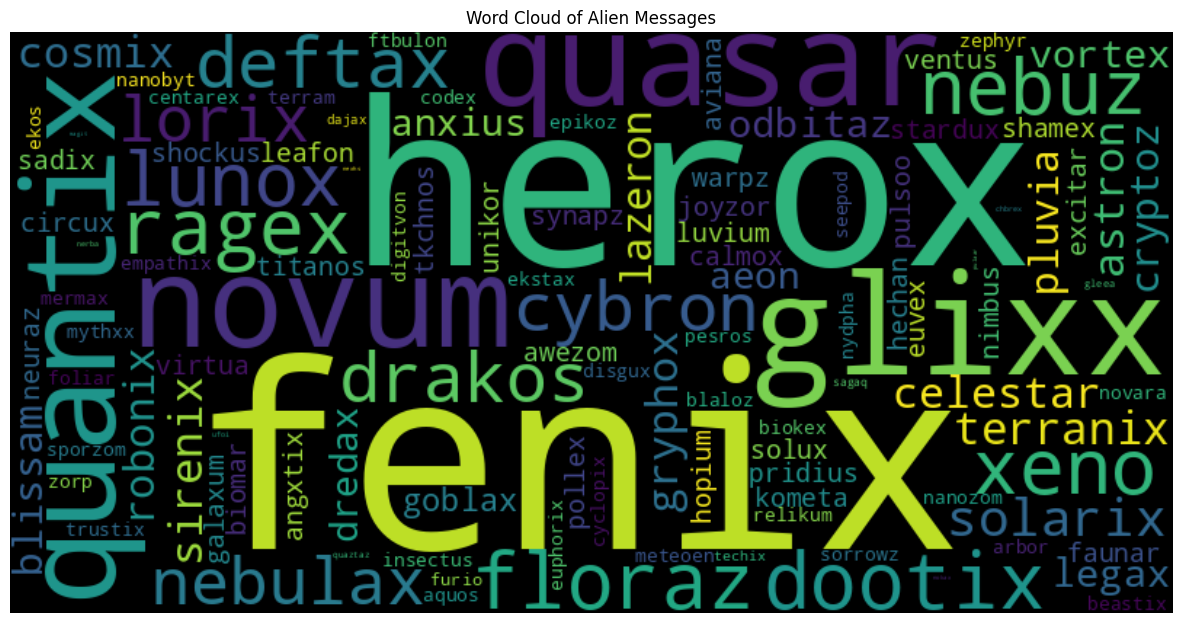

In [71]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_words = ' '.join(df['message_en'])

wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='viridis').generate(all_words)

plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Alien Messages")
plt.show()

NOW, we plot a stacked bar plot to show the distribution of fingers and tail of alien species

In [72]:
import warnings
warnings.filterwarnings("ignore")

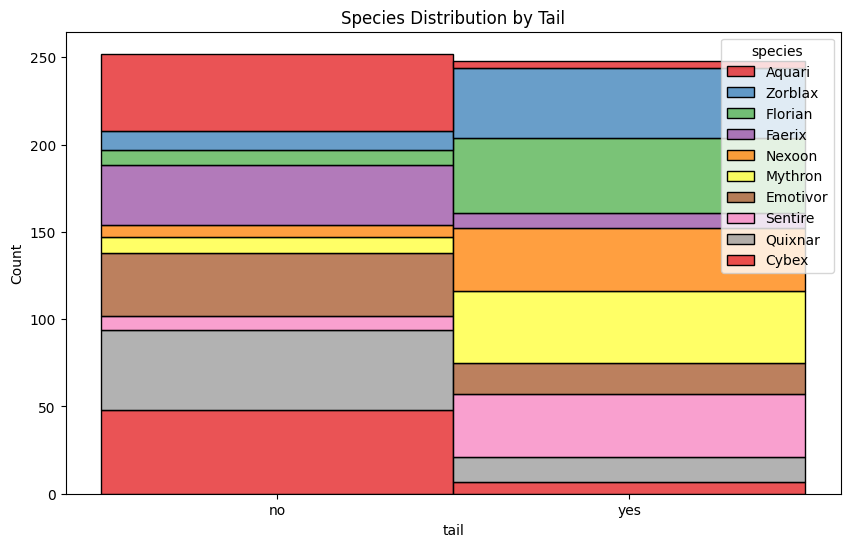

In [85]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='tail', hue='species', multiple='stack', palette='Set1')
plt.title("Species Distribution by Tail")
plt.show()

Now we see which species have how many number of fingers in a stipplot

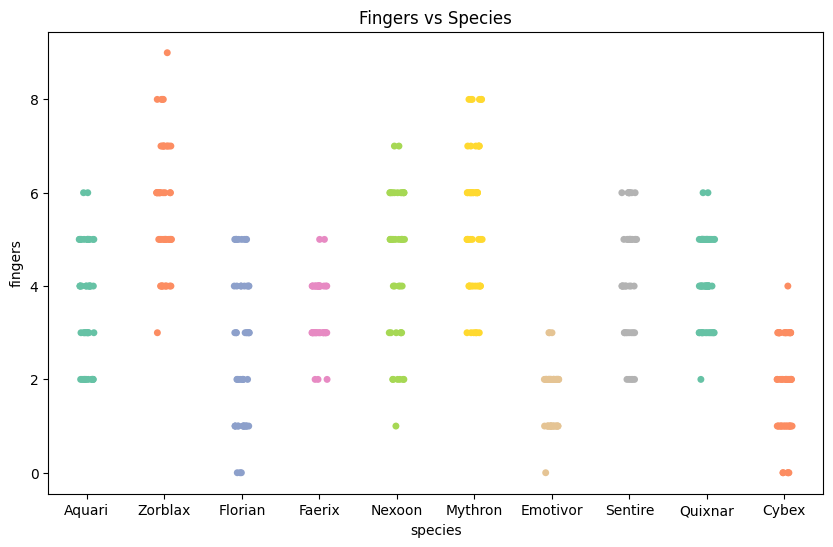

In [86]:
plt.figure(figsize=(10, 6))
sns.stripplot(x='species', y='fingers', data=df, jitter=True, palette='Set2')
plt.title('Fingers vs Species')
plt.show()

Now we plot the most 25 used words in the dataset, and plot their heatmap to see which alien species use which kind of words

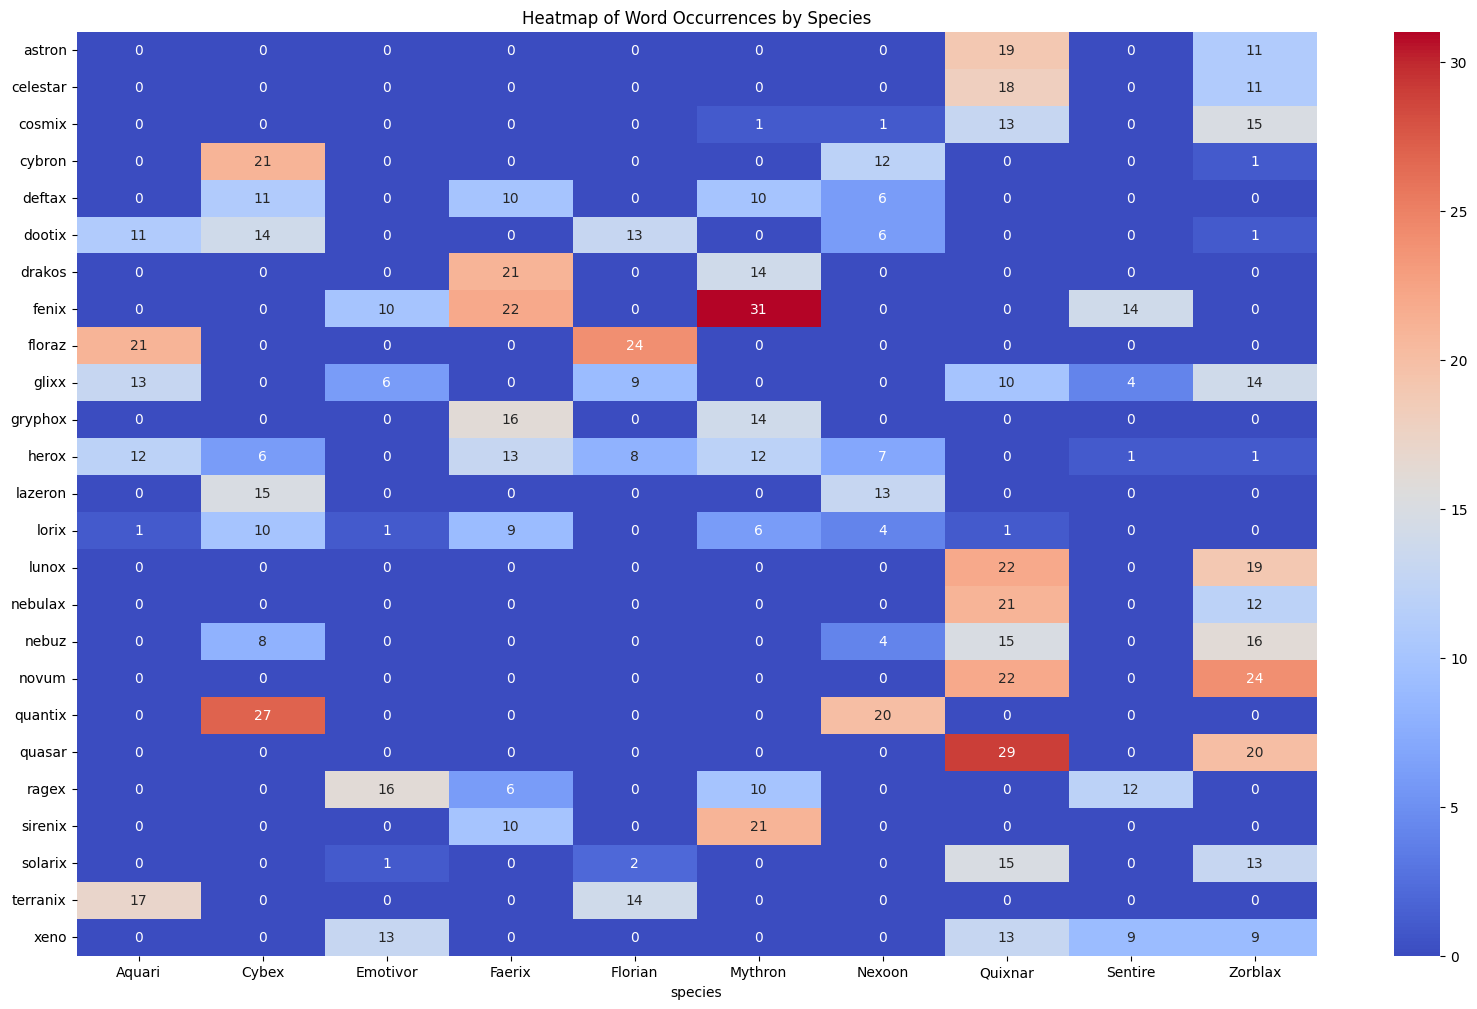

In [87]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=25)  # Limit to 15 most common words for simplicity
word_counts = vectorizer.fit_transform(df['message_en']).toarray()

word_count_df = pd.DataFrame(word_counts, columns=vectorizer.get_feature_names_out())
word_count_df['species'] = df['species']

word_count_grouped = word_count_df.groupby('species').sum()

plt.figure(figsize=(20, 12))
sns.heatmap(word_count_grouped.T, cmap='coolwarm', annot=True, fmt='d')
plt.title("Heatmap of Word Occurrences by Species")
plt.show()

We can easily see that species are being distributed as pairs, as pairs of species use words in common

In [88]:
from collections import Counter

all_words = df['message_en'].str.split().sum()

word_counts = Counter(all_words)

word_frequency_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])
word_frequency_df = word_frequency_df.sort_values(by='Frequency', ascending=False)

In [89]:
vectorizer = CountVectorizer()

vectorizer.fit(df['message_en'].astype(str))

total_vocab_size = len(vectorizer.vocabulary_)
words_n = []
for i in vectorizer.vocabulary_:
    words_n.append(i)

We then made the result df, which contains the mapping of every word in the vocabulary with the number of species that word is being used by, and a list of all such species

In [90]:
df['words'] = df['message_en'].str.split()
exploded = df.explode('words')
result = exploded.groupby('words')['species'].agg(lambda x: list(set(x))).reset_index()
result['number_of_species'] = result['species'].apply(len)
result.columns = ['word', 'species_list', 'number_of_species']

In [91]:
result

,word,species_list,number_of_species
0,aeon,"[Cybex, Nexoon]",2
1,algorid,[Cybex],1
2,angxtix,"[Emotivor, Sentire]",2
3,anxius,"[Emotivor, Sentire]",2
4,aquos,"[Aquari, Florian]",2
5,arbor,"[Aquari, Florian]",2
6,astron,"[Quixnar, Zorblax]",2
7,aviana,"[Aquari, Florian]",2
8,awezom,"[Emotivor, Sentire]",2
9,beastix,"[Faerix, Mythron]",2


**It is very clear that the majority of the words are being spoken by only two species, and such species form pairs.**

In [79]:
binaring_words = result[result['number_of_species']==2]
a = binaring_words.sort_values(by='species_list', ascending=True)
len(a)

95

So, there are 95 total words which are used by only 2 aliens. That is a great insight.

# From observation of result DataFrame using above cell:
We can conclude that:  
1)  Aquari <-> Florian  
    Emotivor <-> Sentire  
    Faerix <-> Mythroon  
    Cybex <-> Nexoon  
    Quixnar <-> Zorblax

2) Also Left side alien speice (in general) above doesn't have tail while right ones have 

Now, we'll predict the pair and store it in df.species_pair and see how much accuracy we get. 

Note: To prevent Null values, we assign an arbitrary pair to that row as there are only 2-4 of them

In [16]:
word_to_pair = a.set_index('word')['species_list'].to_dict()
normalized_word_to_pair = {}

for word, pair in word_to_pair.items():
    # Sort the pair to ensure (a, b) and (b, a) are the same
    sorted_pair = tuple(sorted(pair))
    normalized_word_to_pair[word] = sorted_pair
word_to_pair = normalized_word_to_pair

In [141]:
word_to_pair

# This dataframe assigns a pair to every word in the vocabulary. There are 10 alien species and 5 pairs as already discussed

{'biomar': ('Aquari', 'Florian'),
 'floraz': ('Aquari', 'Florian'),
 'leafon': ('Aquari', 'Florian'),
 'zephyr': ('Aquari', 'Florian'),
 'terram': ('Aquari', 'Florian'),
 'faunar': ('Aquari', 'Florian'),
 'seepod': ('Aquari', 'Florian'),
 'sporzom': ('Aquari', 'Florian'),
 'foliar': ('Aquari', 'Florian'),
 'pollex': ('Aquari', 'Florian'),
 'nerba': ('Aquari', 'Florian'),
 'aviana': ('Aquari', 'Florian'),
 'pesros': ('Aquari', 'Florian'),
 'arbor': ('Aquari', 'Florian'),
 'aquos': ('Aquari', 'Florian'),
 'nimbus': ('Aquari', 'Florian'),
 'terranix': ('Aquari', 'Florian'),
 'pluvia': ('Aquari', 'Florian'),
 'insectus': ('Aquari', 'Florian'),
 'sorrowz': ('Emotivor', 'Sentire'),
 'furio': ('Emotivor', 'Sentire'),
 'luvium': ('Emotivor', 'Sentire'),
 'joyzor': ('Emotivor', 'Sentire'),
 'pridius': ('Emotivor', 'Sentire'),
 'trustix': ('Emotivor', 'Sentire'),
 'hopium': ('Emotivor', 'Sentire'),
 'euphorix': ('Emotivor', 'Sentire'),
 'excitar': ('Emotivor', 'Sentire'),
 'empathix': ('Emotivor

In [17]:
def assign_pair(message):
    words = message.split()
    pairs = {word_to_pair[word] for word in words if word in word_to_pair}
    return pairs.pop() if pairs else ['Aquari', 'Florian'] # Only 2-3 cases where a binaring word is not found
# For those cases, we assign an arbitrary value

df['species_pair'] = df['message_en'].apply(assign_pair)

# encoding species pairs into separate columns
df['species_1'] = df['species_pair'].apply(lambda x: x[0] if x else 'Cybex')
df['species_2'] = df['species_pair'].apply(lambda x: x[1] if x else 'Nexoon')

In [18]:
species_pairs = [
    ('Aquari', 'Florian'),
    ('Emotivor', 'Sentire'),
    ('Faerix', 'Mythron'),
    ('Cybex', 'Nexoon'),
    ('Quixnar', 'Zorblax')
]

In [19]:
print(len(df))
count = len(df[df.apply(lambda row: row['species'] in row['species_pair'], axis=1)])
count

500


497

When we assign pairs, the probability that the correct label is there in the pair is over 99%. That is a great start.

In [20]:
df['species_1_en'] = label_encoder.transform(df['species_1'])
df['species_2_en'] = label_encoder.transform(df['species_2'])

Now we'll train a decision tree classifier with input features being species 1, species 2, tail and fingers

In [21]:
X = df[['species_1_en', 'species_2_en', 'tail_en', 'fingers']]
y = df['species_en']

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

m = DecisionTreeClassifier()
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
m.fit(X_train, y_train)


y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.83      0.91         6
           2       1.00      1.00      1.00         7
           3       1.00      0.86      0.92         7
           4       0.80      1.00      0.89         4
           5       0.88      1.00      0.93         7
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         3

    accuracy                           0.96        50
   macro avg       0.97      0.97      0.97        50
weighted avg       0.97      0.96      0.96        50



# 97 % accuracy on such a dataset is a big plus.

> Normal methods like using embeddings for text, concatinating the features together, and then train a neural network based on LSTM, Transformers, MLP, etc. would not be good for this problem statement as there is no relation between words, and the messages don't form any semantic sense and are randomly put together set of words.
> 
> So, bag of words would be a better alogorithm, put together with RandomForestClassifier. But that too gives only around 83% accuracy as the dataset is quite small and constrained.

# Let us plot the tree from the decision tree classifier for interpretability

In [165]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import graphviz
from sklearn.tree import export_graphviz
import re

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

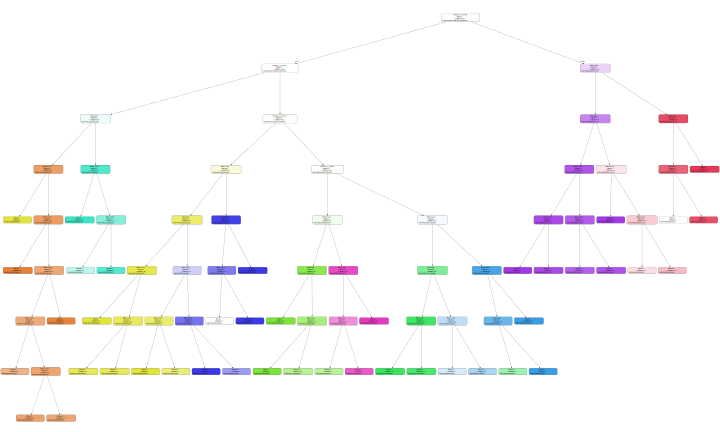

In [166]:
draw_tree(m, X , size = 10)

We can easily zoom in and see by changing the size as an argument

# Now let us apply the same preprocessing in the test.csv and do the predictions

In [45]:
test = pd.read_csv('/kaggle/input/aries-iitd-alien/test.csv')
dfn = test

In [46]:
vectorizer = CountVectorizer()
vectorizer.fit(dfn['message'].astype(str))

dfn['tail_en'] = dfn['tail'].apply(lambda x: 1 if x=='yes' else 0)

total_vocab_size = len(vectorizer.vocabulary_)
words = []
for i in vectorizer.vocabulary_:
    words.append(i)
    
similar_word_groups = group_similar_words(words)

word_map = {}

for group in similar_word_groups:
    representative_word = group[0] 
    for word in group:
        word_map[word] = representative_word
        
def replace_similar_words(text, word_map):
    tokens = text.split()
    replaced_tokens = [word_map.get(token, token) for token in tokens]
    return ' '.join(replaced_tokens)
dfn['message_en'] = dfn['message'].apply(lambda x: replace_similar_words(x, word_map))

In [47]:
len(words)

434

In [48]:
all_words = dfn['message_en'].str.split().sum()

word_counts = Counter(all_words)

word_frequency_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])
word_frequency_df = word_frequency_df.sort_values(by='Frequency', ascending=False)

vectorizer = CountVectorizer()

vectorizer.fit(dfn['message_en'].astype(str))

total_vocab_size = len(vectorizer.vocabulary_)
words_n = []
for i in vectorizer.vocabulary_:
    words_n.append(i)

In [49]:
len(words_n)

118

So, in the test set, there are a total of 118 words after grouping similiar words together as we did in the data

In [54]:
# Same as whatever we did above
dfn['species_pair'] = dfn['message_en'].apply(assign_pair)

# encoding species pairs into separate columns
dfn['species_1'] = dfn['species_pair'].apply(lambda x: x[0] if x else 'Cybex')
dfn['species_2'] = dfn['species_pair'].apply(lambda x: x[1] if x else 'Nexoon')

In [55]:
dfn['species_1_en'] = label_encoder.transform(dfn['species_1'])
dfn['species_2_en'] = label_encoder.transform(dfn['species_2'])

In [56]:
X_pred = dfn[['species_1_en', 'species_2_en', 'tail_en', 'fingers']]

In [57]:
final_pred = clf.predict(X_pred)

In [58]:
df_pred = pd.DataFrame(final_pred, columns = ['labels']) # Making a dataframe

In [59]:
df_pred['species'] = label_encoder.inverse_transform(df_pred['labels']) #Inversing the encoding as species have names

In [60]:
df_pred.drop(columns = ['labels'], inplace = True) # Delete the labels column now as we have names

In [61]:
df_pred.to_csv('csubmission.csv', index = False) # Our Submission

# Thank you